## This is the 2-layer neural network workbook for ECE 239AS Assignment #3

Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a two layer neural network.

In [42]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass

In [43]:
from nndl.neural_net import TwoLayerNet

In [44]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
net.params['W1']
X, y = init_toy_data()

### Compute forward pass scores

In [45]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231222787662e-08


### Forward pass loss

In [46]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0


In [47]:
print(loss)

1.071696123862817


### Backward pass

Implements the backwards pass of the neural network.  Check your gradients with the gradient check utilities provided.

In [48]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)
# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.253614690945947e-09
W2 max relative error: 2.9632227682005116e-10
b1 max relative error: 3.172680092703762e-09
b2 max relative error: 1.616096555269559e-09


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the softmax and SVM.

iteration 0 / 100: loss 1.1101173813601373
Final training loss:  0.0144978645877649


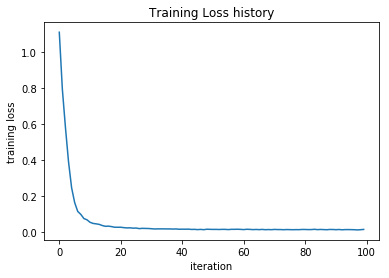

In [49]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [50]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # X_test 1000 * D
    # mask : [49000, 50000) for validation data
    mask = list(range(num_training, num_training + num_validation))      
    X_val = X_train[mask]
    y_val = y_train[mask]
    
     # X_train : 49000 * D 
    # mask : [0 49000) for training data
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    # X_test 1000 * D
    # mask : [0 1000) for testing data
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)           # across columns to average over training set
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows (changing from 4D to 2D by vectorizing the image tensor)
    X_train = X_train.reshape(num_training, -1)   # 49000 x 3072
    X_val = X_val.reshape(num_validation, -1)     # 1000 x 3072
    X_test = X_test.reshape(num_test, -1)         # 1000 x 3072

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 28-29%.

In [51]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 2.302757518613176
iteration 100 / 1000: loss 2.3021201592072376
iteration 200 / 1000: loss 2.2956136007408694
iteration 300 / 1000: loss 2.251825904316415
iteration 400 / 1000: loss 2.188995235046778
iteration 500 / 1000: loss 2.1162527791897756
iteration 600 / 1000: loss 2.0646708276982175
iteration 700 / 1000: loss 1.9901688623083942
iteration 800 / 1000: loss 2.0028276401246847
iteration 900 / 1000: loss 1.946517681785648
Validation accuracy:  0.283


## Questions:

The training accuracy isn't great.  

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?


In [52]:
stats['train_acc_history']

[0.095, 0.15, 0.25, 0.25, 0.315]

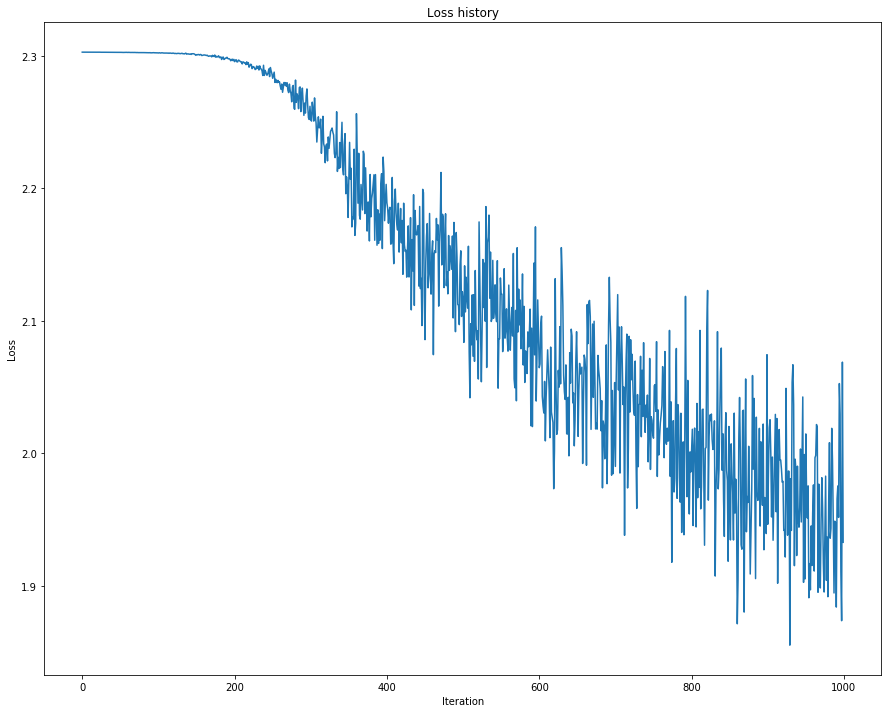

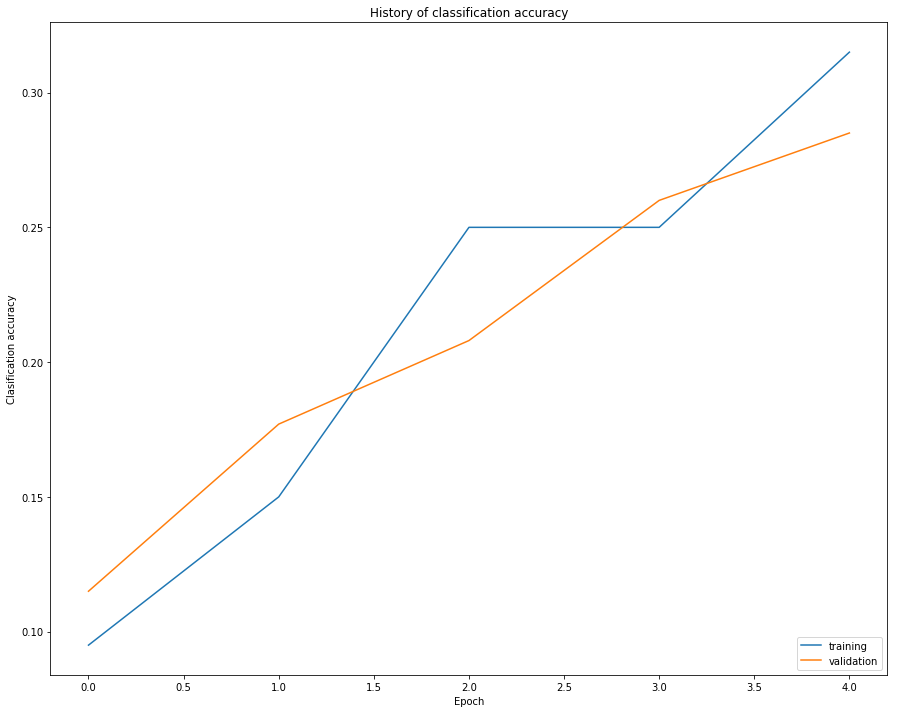

In [56]:
# ================================================================ #
# YOUR CODE HERE:
#   Do some debugging to gain some insight into why the optimization
#   isn't great.
# ================================================================ #

# Plot the loss function and train / validation accuracies

plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 12)
plt.show()

fig, ax = plt.subplots()
plt.plot(stats['train_acc_history'], label='training')
plt.plot(stats['val_acc_history'], label='validation')

legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.title('History of classification accuracy')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()



pass
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Answers:

(1) From the Loss histort figure we can see the loss function decreases at very slow rate especially at the begining. This suggests that the learning rate is low and not large enough. Moreover, after around interation 230, the lost function starts to show jittery behaviour. To avoid slow learning rate we increase the learning rate. Also we could have play with decay rate and/or batch size as another hyperparameter to treat jittery behaviour but we only chose batch size to do this since too many hyperparameters are computationally expensive to tweak. Hence, we keep the decay rate fixed but treat the learning rate and batch sizes as hyperparameters.

From the Classification history, we observe that during training both the training accuracy and validation accuracy are increasing and we do not get to see decrease in validation accuracy corresponding to overfitting the data. This suggest that our model is too simple for the training data and we are smoothing the model too much. For example, one way to solve this is to treat ragression factor as hyperparameter.

(2) By choosing optimal hyperparameters inclduing learning rate, regression coefficent, and batch_size.

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [54]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 50% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 28%)) / %22, 1) 
#   where if you get 40% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #

Satisfactory_accuracy = 0.50

# hyperparameters
N_batch_min = 220
N_batch_max = 240

Learning_rate_min = -3.5
Learning_rate_max = -3

N_ragression_min = 0.1
N_ragression_max = 0.25


batch_values = list(np.arange(N_batch_min,N_batch_max,10))
rate_values = list(10**np.arange(Learning_rate_min,Learning_rate_max,0.2))
ragression_values = list(np.arange(N_ragression_min,N_ragression_max,0.05))

done1 = False
done2 = False

for batch in batch_values:
    for rate in rate_values:
        for ragression in ragression_values:

            #creating neural netwrok
            NeuralNetwork = TwoLayerNet(input_size, hidden_size, num_classes)

                #training network
            NeuralNetwork.train(X_train, y_train, X_val, y_val,
                num_iters=3000, batch_size=batch,
                learning_rate=rate, learning_rate_decay=0.95,   
                reg=ragression, verbose=False)

            val_acc = (NeuralNetwork.predict(X_val) == y_val).mean()
            print('Validation accuracy:', val_acc, '     Batch_size:', batch, 'Learning Rate:', rate, 'Regression coefficent:', ragression)
            
            
            if val_acc >= Satisfactory_accuracy:
                net = NeuralNetwork
                done1 = True
                print('Validation accuracy:', val_acc, '  Best Net:   Batch_size:', batch, 'Learning Rate:', rate, 'Regression coefficent:', ragression)
                break
        if done1:
            done2 = True
            break
            
    if done2:
        break
           

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
best_net = net

Validation accuracy: 0.478      Batch_size: 220 Learning Rate: 0.00031622776601683794 Regression coefficent: 0.1
Validation accuracy: 0.492      Batch_size: 220 Learning Rate: 0.00031622776601683794 Regression coefficent: 0.15000000000000002
Validation accuracy: 0.476      Batch_size: 220 Learning Rate: 0.00031622776601683794 Regression coefficent: 0.20000000000000004
Validation accuracy: 0.504      Batch_size: 220 Learning Rate: 0.0005011872336272725 Regression coefficent: 0.1
Validation accuracy: 0.504   Best Net:   Batch_size: 220 Learning Rate: 0.0005011872336272725 Regression coefficent: 0.1


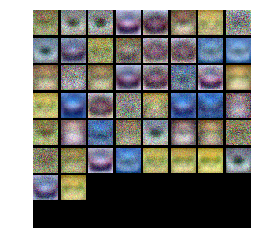

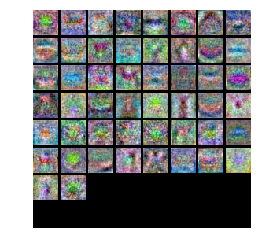

In [55]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

## Question:

(1) What differences do you see in the weights between the suboptimal net and the best net you arrived at?

## Answer:

(1) many of the weights in the suboptimal net are indistinguishable from each other and they look much like white noise. This makes it hard for the net to capture and expresses differences between different pictures (e.g. cat and dog). As a result, the classification is hard with this suboptimal net and, as it can be seen, using this net is resulted in only 28.3% validation accuracy. On the other hand, as it can be seen the weights in the optimal (best) net (validation accuracy above 50%) are different from each other (they are not just random values) and as it can be confirmed, these weights are much better to capture and express differences in different images which has been resulted in much higher validation accuracy of 50.4% compared to the suboptimal net. 

## Evaluate on test set 

In [59]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.509
